In [1]:
!pip download pylibjpeg
!pip download pylibjpeg-openjpeg
!pip download pylibjpeg-libjpeg 
!pip download pydicom 
!pip download python-gdcm
!pip download dicomsdl

!pip install pylibjpeg --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read
!pip install pylibjpeg-openjpeg --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read
!pip install pylibjpeg-libjpeg --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read
!pip install pydicom --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read
!pip install python-gdcm --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read
!pip install dicomsdl --no-index --find-links=file:///kaggle/input/read-dicom-set/dicom_read

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 13.7 MB/s eta 0:00:0000:0100:01
Saved ./pylibjpeg-1.4.0-py3-none-any.whl
Saved ./numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Successfully downloaded pylibjpeg numpy
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.5 MB/s eta 0:00:0000:0100:010m
  File was already downloaded /kaggle/working/numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Saved ./pylibjpeg_openjpeg-1.3.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Successfully downloaded pylibjpeg-openjpeg numpy
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.5 MB/s eta 0:00:0000:0100:010m
  File was already

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import pydicom
import PIL
import cv2

The data has been loaded to a Pandas DataFrame for EDA.

In order to organize the data more efficiently, the complete image file path has been generated and added to a new column: 'image_path'.

In [136]:
train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

base_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/'

train['image_path'] = np.nan

for row in tqdm(range(len(train))):
    train['image_path'].iloc[row] = base_path + str(train['patient_id'].iloc[row]) + '/' + str(train['image_id'].iloc[row]) + '.dcm'

  0%|          | 0/54706 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 54706/54706 [00:24<00:00, 2212.97it/s]


The column information was analyzed.

In [138]:
train.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case', 'image_path'],
      dtype='object')

Histograms of the appropriate columns / potential features were produced.

The average age in a negative case is: 58.43280820765824 .
The average age in a positive case is: 63.67875647668394 .

The standard deviation in a negative case is: 10.023209994270674 .
The standard deviation in a positive case is: 9.991980250443879 .



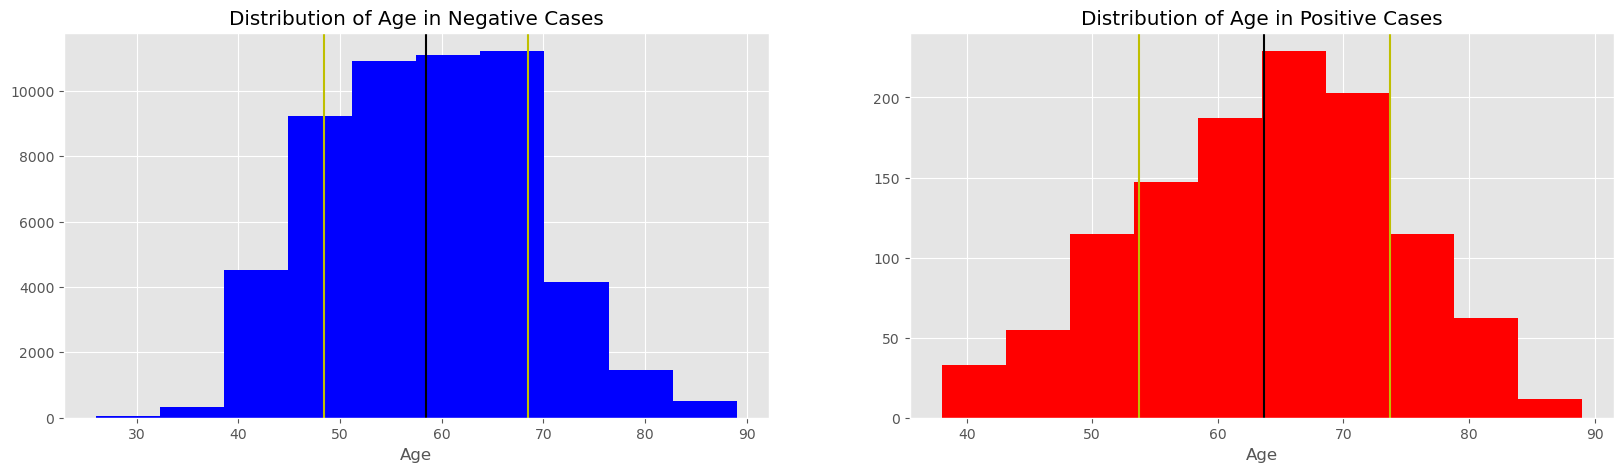

In [139]:
fig, ax = plt.subplots(1, 2, figsize = (20,5))
plt.style.use('ggplot')

ax[0].set_title('Distribution of Age in Negative Cases')
ax[0].set_xlabel('Age')
ax[0].hist(train[train['cancer'] == 0]['age'], color = 'blue')
ax[0].axvline(x = train[train['cancer'] == 0]['age'].mean(), color = 'black', label = 'Average')
ax[0].axvline(x = train[train['cancer'] == 0]['age'].mean() + train[train['cancer'] == 0]['age'].std(), color = 'y', label = 'Upper STD')
ax[0].axvline(x = train[train['cancer'] == 0]['age'].mean() - train[train['cancer'] == 0]['age'].std(), color = 'y', label = 'Lower STD')

ax[1].set_title('Distribution of Age in Positive Cases')
ax[1].set_xlabel('Age')
ax[1].hist(train[train['cancer'] == 1]['age'], color = 'red')
ax[1].axvline(x = train[train['cancer'] == 1]['age'].mean(), color = 'black', label = 'Average')
ax[1].axvline(x = train[train['cancer'] == 1]['age'].mean() + train[train['cancer'] == 1]['age'].std(), color = 'y', label = 'Upper STD')
ax[1].axvline(x = train[train['cancer'] == 1]['age'].mean() - train[train['cancer'] == 1]['age'].std(), color = 'y', label = 'Lower STD')

print('The average age in a negative case is:', train[train['cancer'] == 0]['age'].mean(), '.')
print('The average age in a positive case is:', train[train['cancer'] == 1]['age'].mean(), '.')
print()
print('The standard deviation in a negative case is:', train[train['cancer'] == 0]['age'].std(), '.')
print('The standard deviation in a positive case is:', train[train['cancer'] == 1]['age'].std(), '.')
print()

Some insights:
* Most patients are above 40 years old.
* The number of patients seem to drop after 70.
* Most cancer patients are above 50 years old.

The number of negative cases is: 11907 .
The number of positive cases is: 486 .



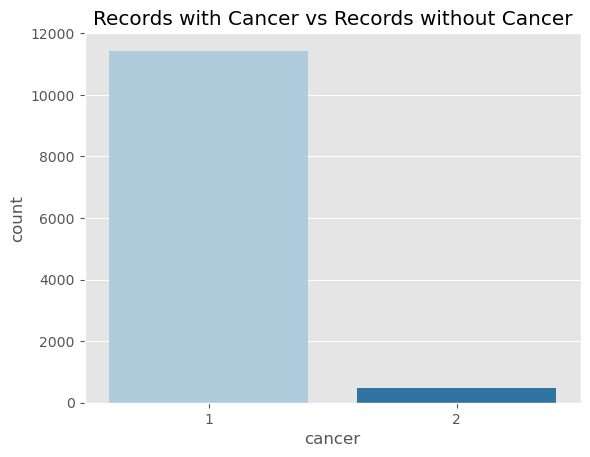

In [149]:
fig, ax = plt.subplots()
sns.countplot(x = 'cancer', data = train.groupby('patient_id').nunique(), palette = 'Paired')
ax.set_title('Records with Cancer vs Records without Cancer')

print('The number of negative cases is:', len(train[train['cancer'] == 0].groupby('patient_id').nunique()), '.')
print('The number of positive cases is:', len(train[train['cancer'] == 1].groupby('patient_id').nunique()), '.')
print()

This tells me that this is very unbalanced data. There are many more negative scans than positive scans. This will make training with the images more difficult.

The dicom images need to be converted in order to further analyze them.

In [ ]:
!pip install -U dicomsdl
import dicomsdl as dicom
dset = dicom.open(train.image_path.iloc[12])
print (dset.pixelData())

In [ ]:
RESIZE_TO = (256, 256)

def dicom_file_to_ary_pil(path):
    image = dicom.open(path)
    data = image.pixelData()
    if image.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
dicom_file_to_ary_pil(train.image_path.iloc[1]).shape

In [ ]:
def dicom_file_to_ary_cv2(path):
    image = dicom.open(path)
    data = image.pixelData()
       
    data = (data - data.min()) / (data.max() - data.min())
    
    if image.PhotometricInterpretation == "MONOCHROME1":
        data = 1 - data
        
    data = cv2.resize(data, RESIZE_TO)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
dicom_file_to_ary_cv2(train.image_path.iloc[12]).shape

In [ ]:
train['img_array'] = np.array

for row in tqdm(range(len(train))):
    try:
        train['img_array'].iloc[row] = dicom_file_to_ary_cv2(train.image_path.iloc[row])
    except:
        train['img_array'].iloc[row] = [0]
        print('Error on image: ', row)